In [1]:
import os
import glob
import operator  as op
import functools as ft

import numpy             as np
import matplotlib.pyplot as plt

from CCutils import lmap
from CCutils import npmap
from CCfun   import in_range
from CCfun   import compute_baseline_float
from CCfun   import datetime_from_spectrum

from CCplot  import plot1d
from CCplot  import plot_line
from CCplot  import auto_plot_style
from CCplot  import figure_sizes
from CCplot  import subplots

from CCfit   import shifted_gauss
from CCfit   import shifted_expo
from CCfit   import fit

from CCio    import load_ccd_file

In [2]:
maindir = "/home/gonzalo/data/CC/caf_bleaching/"

auto_plot_style({"lines.markersize" : 10})

_peaks = {600: 770, 410: 770, 400: 770, 350: 630}

In [3]:
def orderer(filename):
    basename = filename.split("/")[-1]
    tokens   = basename.split("_")
    index    = 0
    for token in tokens:
        if token[0].isdigit():
            index = 100 * index + int(token)
    return index

def find_max(x, y):
    m  = in_range(x, 600, 900)
    return y[m].max()

def sum_(x, y):
    m  = in_range(x, 600, 900)
    return y[m].sum()

def integrate(emwl, spectrum, exwl, rebin_by=1, plot=False):
    x  = emwl
    y  = spectrum
    y -= compute_baseline_float(y)
    if rebin_by > 1:
        x = rebin(x, rebin_by, np.mean)
        y = rebin(y, rebin_by, np.sum )
    
    y  = y[x > exwl + 30]
    x  = x[x > exwl + 30]
    p  = _peaks[exwl]

    s  = find_max(x, y), p,  30,  0
    f  = fit(shifted_gauss, x, y, s, fit_range = (p - 300, p + 300), maxfev=int(1e6))
    if plot:
        plt.figure()
        plt.plot(x, y, "k.")
        plt.plot(x, f.fn(x), "b-")
    return f.values[0] * np.diff(x)[0]

def fit_selfbleach(x, y):
    s  = 1e9, -50, 5e9
    f  = fit(shifted_expo, x, y, s, maxfev=int(1e6))
    plt.scatter(x, y)
    plt.plot(x, f.fn(x), "y-")
    return f.values[0], -f.values[1], f.values[2]

def analyze(filenames, exwl, plot=False):
    datas     =  lmap(load_ccd_file, filenames)
    em_wls    =  lmap(op.attrgetter("em_wl"), datas)
    times     = npmap(datetime_from_spectrum, datas)
    times     = npmap(op.attrgetter("seconds"), times - times[0]) * 1.0
    spectra   = [s.rate / s.power.mean for s in datas]
    peaks     = npmap(sum_, em_wls, spectra)
    integrals = npmap(ft.partial(integrate, exwl=exwl, plot=plot), em_wls, spectra)
    return times, integrals

# Bleach

In [4]:
folders   = glob.glob(os.path.join(maindir, "*"))
integrals = dict()
for folder in folders:
    main_wl, bleach_wl = map(int, os.path.basename(folder).split("_"))
    if main_wl not in integrals: integrals[main_wl] = dict()
    
    filenames = sorted(glob.glob(os.path.join(folder, "*signal.asc")), key=orderer)
    integrals[main_wl][bleach_wl] = analyze(filenames, main_wl)

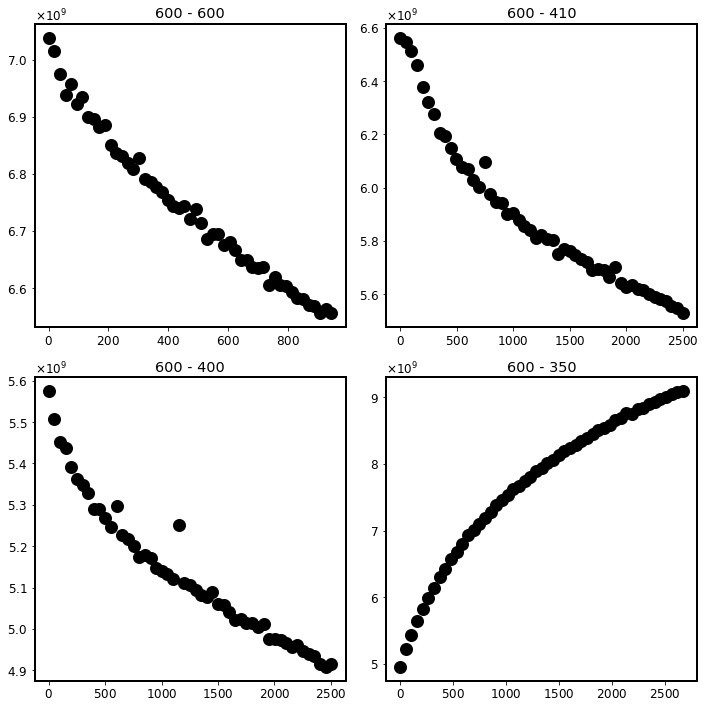

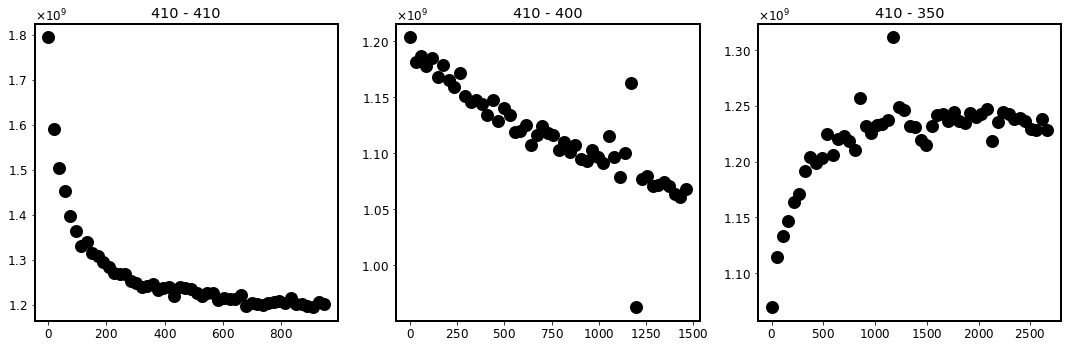

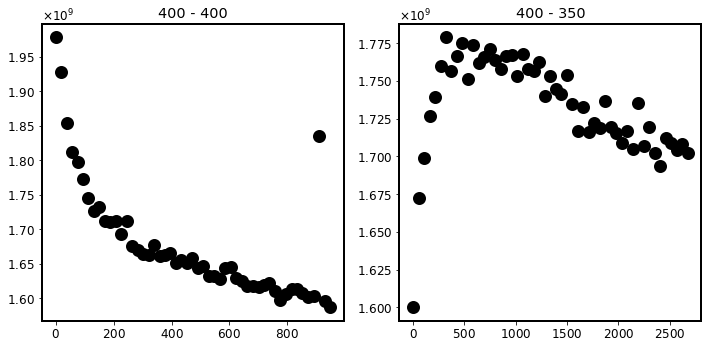

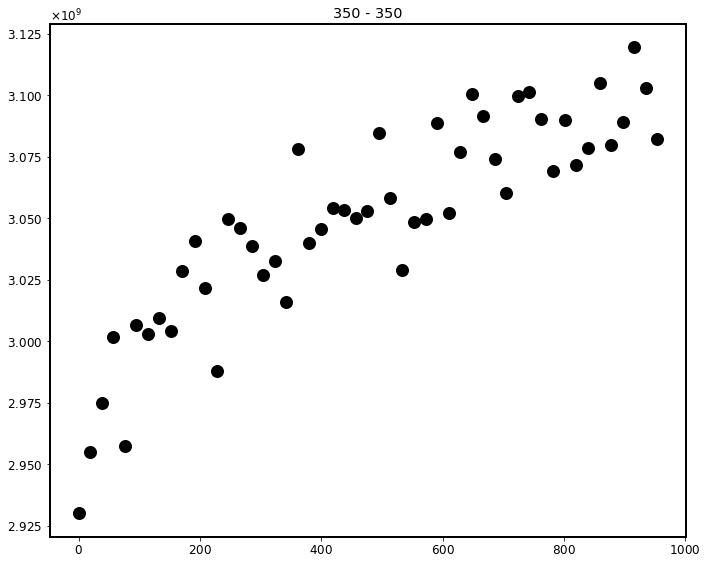

In [7]:
for main_wl, bleachs in sorted(integrals.items(), reverse=True):
    n = len(bleachs)
    plt.figure(figsize=figure_sizes[n])
    k = 1
    for bleach_wl, (t, i) in sorted(bleachs.items(), reverse=True):
        plt.subplot(*subplots[n], k)
        plt.scatter(t, i)
        #plt.ylim(0, plt.ylim()[1])
        plt.title(f"{main_wl} - {bleach_wl}")

        k += 1
    plt.tight_layout()